<a href="https://colab.research.google.com/github/singhaniasnigdha/food-rec/blob/main/FoodRec_tSNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/maciejkula/spotlight.git@master#egg=spotlight
!pip install lightfm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
nltk.download('wordnet')
nltk.download('stopwords')


from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords

from spotlight.interactions import Interactions, SequenceInteractions
from spotlight.cross_validation import random_train_test_split
from spotlight.factorization.implicit import ImplicitFactorizationModel
from spotlight.sequence.implicit import ImplicitSequenceModel

from sklearn.preprocessing import LabelEncoder
from collections import Counter
from copy import deepcopy
from pprint import pprint

from lightfm import LightFM

import string
import torch
import warnings
warnings.simplefilter('ignore')

from google.colab import drive
drive.mount('/content/drive')

root_path = '/content/drive/My Drive/AML/Food.com/'
# root_path = '/content/drive/My Drive/Food.com/'

  Cloning https://github.com/maciejkula/spotlight.git (to revision master) to /tmp/pip-install-7r972z79/spotlight
  Running command git clone -q https://github.com/maciejkula/spotlight.git /tmp/pip-install-7r972z79/spotlight
  Created wheel for spotlight: filename=spotlight-0.1.6-cp36-none-any.whl size=33921 sha256=2012b1d4ef6689e8fbf591a75071ce9d516c9d9a605535577bbfe587e77f081c
  Stored in directory: /tmp/pip-ephem-wheel-cache-_z3bru2q/wheels/de/0f/85/71b17c59d32cb9d29c31d4ffb16eb14f4cc153f1e28c7a3efb
Successfully built spotlight
     |████████████████████████████████| 317kB 5.8MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp36-cp36m-linux_x86_64.whl size=704267 sha256=7d180f93ace72ba41c12b3e62581847d86345b50fe17bf266713f1462c29e2c1
  Stored in directory: /root/.cache/pip/wheels/c6/64/d4/673c7277f71ac4c5ad4835b94708c01b653ef2d3aa78ef20aa
Successfully built lightfm
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nlt

In [ ]:
'''
Pruning
'''

class value_encoder:
  def __init__(self):
    self.value_map = {}

  def fit(self, data):
    counter = 1
    for val in sorted(deepcopy(data)):
      if val not in self.value_map:
        self.value_map[val] = counter
        counter += 1
  
  def transform(self, val):
    return self.value_map.get(val, 0)

  def get_size(self):
    return len(self.value_map)

interactions = pd.read_csv(root_path + 'interactions_train.csv')
print(f'{interactions["user_id"].nunique()} -- {interactions["recipe_id"].nunique()}')

# Data Pre-processing
# Remove recipes that occur <= 3 times
freq_user = interactions['user_id'].value_counts()
interactions = interactions[interactions['user_id'].isin(freq_user[freq_user > 3].index)]
interactions = interactions[interactions['user_id'].isin(freq_user[freq_user < 75].index)]
freq_recipe = interactions['recipe_id'].value_counts()
interactions = interactions[interactions['recipe_id'].isin(freq_recipe[freq_recipe > 3].index)]

freq_user = interactions['user_id'].value_counts()
interactions = interactions[interactions['user_id'].isin(freq_user[freq_user > 3].index)]

print('After pre-processing')
print(f'{interactions["user_id"].nunique()} -- {interactions["recipe_id"].nunique()}')

# Create Dataset
clickstream_tr = interactions[['user_id', 'recipe_id', 'date','rating']]
clickstream_tr['date'] = pd.to_datetime(clickstream_tr['date'])

user_lr = value_encoder()
user_lr.fit(clickstream_tr['user_id'].unique())
clickstream_tr['user_id'] = clickstream_tr['user_id'].apply(user_lr.transform)

recipe_lr = value_encoder()
recipe_lr.fit(clickstream_tr['recipe_id'].unique())
clickstream_tr['recipe_id'] = clickstream_tr['recipe_id'].apply(recipe_lr.transform)

'''
Split into training and test
'''
clickstream_tr = clickstream_tr.sort_values(by=['user_id', 'date'])
data_test = clickstream_tr.groupby(by='user_id').tail(1)
data_train = clickstream_tr.drop(data_test.index)

n_users = clickstream_tr['user_id'].max()
n_items = clickstream_tr['recipe_id'].max()

# For Spotlight
train = Interactions(data_train['user_id'].values, data_train['recipe_id'].values, data_train['rating'].values, 
                     data_train['date'].values, num_items=n_items+1)

test = Interactions(data_test['user_id'].values, data_test['recipe_id'].values, 
                              data_test['rating'].values, data_test['date'].values, 
                              num_users=train.num_users, num_items=train.num_items)
print(train, test)

# Recipes seen by User in training
seen_recipes = data_train.groupby(by='user_id')['recipe_id'].apply(list).to_dict()
c=0
for k, v in seen_recipes.items():
  if len(v) != len(set(v)):
    c+=1
print(f'C={c}')

25076 -- 160901
After pre-processing
12840 -- 12353
<Interactions dataset (12841 users x 12354 items x 138235 interactions)> <Interactions dataset (12841 users x 12354 items x 12840 interactions)>
C=0


In [ ]:
len(set(interactions['recipe_id'].unique()).intersection(recipes['id'].unique()))

1587

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

# Get recipe ids remaining after filtering
inv_recipe_map = {v: k for k, v in recipe_lr.value_map.items()}
recipe_idx = [v for k, v in sorted(inv_recipe_map.items())]

ps = PorterStemmer()
en_stopwords = stopwords.words('english')
en_punctuations = str.maketrans('', '', string.punctuation)

def preprocess(text):
  text = text.strip().lower().translate(en_punctuations)

  # Stem and remove stopwords
  stemmed = [ps.stem(token) for token in text.split() if token not in en_stopwords]

  # Remove single chars
  return [token for token in stemmed if len(token) > 1]

recipes = pd.read_csv(root_path + 'RAW_recipes.csv')
recipes = recipes[recipes['id'].isin(recipe_idx)]
recipes['tags'] = recipes['tags'].apply(eval)
# recipes['tags_str'] = recipes['tags'].apply(lambda x: ' '.join(x))
# recipes['ingredients_str'] = recipes['ingredients'].apply(lambda x: ' '.join(x))
# print(recipes[['tags_str']])
# recipes['features'] = recipes[['tags', 'ingredients']].values.tolist()
recipes['features'] = recipes[['tags']].values.tolist()
recipes['features'] = recipes['features'].apply(lambda t: preprocess(' '.join(map(str, t))))
print(recipes['features'])


# One-hot encoding for item attributes - using 'text' field which is created
# while pre-processing and combining name, tags, description and ingredients
mlb = MultiLabelBinarizer()
item_features = mlb.fit_transform(recipes['features'].values)
# print(list(mlb.classes_))
print(f'No of Features = {item_features.shape[1]}')

15        [weeknight, timetomak, cours, mainingredi, pre...
16        inutesorless, timetomak, cours, mainingred...
33        inutesorless, timetomak, cours, mainingred...
36        inutesorless, timetomak, cours, mainingred...
40        inutesorless, timetomak, cours, mainingred...
                                ...                        
231539    inutesorless, timetomak, cours, prepar, pa...
231542    [weeknight, timetomak, cours, mainingredi, pre...
231554    inutesorless, timetomak, cours, mainingred...
231561    inutesorless, timetomak, cours, mainingred...
231600    inutesorless, timetomak, cours, prepar, oc...
Name: features, Length: 12353, dtype: object
No of Features = 453


In [ ]:
from collections import Counter
tag_counts = Counter(recipes['features'].sum()).most_common()
tags_to_remove = []
for row in tag_counts:
  if row[1] <= 5 or row[1] > 3000:
    tags_to_remove.append(row[0])
print(tags_to_remove)
item_dict = dict(zip(mlb.classes_, mlb.transform(mlb.classes_[:, np.newaxis]).argmax(axis=1)))
idx_to_remove = [item_dict[t] for t in tags_to_remove]
print(idx_to_remove)

['prepar', 'timetomak', 'cours', 'dietari', 'mainingredi', 'occas', 'equip', 'easi', 'cuisin', 'lowinsometh', 'maindish', '60minutesorless', 'tastemood', 'meat', 'numberofserv', 'oven', 'northamerican', '30minutesorless', 'veget', 'a1sauc', 'chickenliv', 'turkeyburg', 'beefliv', 'malaysian', 'wholeturkey', 'papaya', 'reynoldswrap', 'mussel', 'costarican', 'pakistani', 'kiwifruit', 'chilean', 'smoker', 'meatloaf', 'finnish', 'austrian', 'brazilian', 'pheasant', 'squid', 'duck', 'halloweencak', 'chutney', 'peruvian', 'oyster', 'bass', 'rabbit', 'argentin', 'colleg', 'wholeduck', 'ethiopian', 'leftov', 'iraqi', 'perch', 'hunan', 'beefkidney', 'dipslunchsnack', 'octopu', 'zucchini', 'micromelanesia', 'aprilfoolsday', 'memorialday', 'duckbreast', 'cincodemayo', 'venezuelan', 'birthday', 'crawfish', 'oaxacan', 'mongolian', 'meatbal', 'halloweencupcak', 'brew', 'ragurecipecontest', 'pumpkin', 'pumpkinbread', 'breadpud', 'sudanes', 'nutfre', 'nepales', 'elk', 'moos', 'unprocessedfreez']
[320, 

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import time

new_features = item_features[:, sorted(set(range(len(mlb.classes_))).difference(idx_to_remove))]

pca_x = PCA(n_components=100).fit_transform(new_features)

time_start = time.time()

tsne_x = TSNE(n_components=2, verbose=2, early_exaggeration=2, perplexity=50).fit_transform(pca_x)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 12353 samples in 0.176s...
[t-SNE] Computed neighbors for 12353 samples in 49.275s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12353
[t-SNE] Computed conditional probabilities for sample 2000 / 12353
[t-SNE] Computed conditional probabilities for sample 3000 / 12353
[t-SNE] Computed conditional probabilities for sample 4000 / 12353
[t-SNE] Computed conditional probabilities for sample 5000 / 12353
[t-SNE] Computed conditional probabilities for sample 6000 / 12353
[t-SNE] Computed conditional probabilities for sample 7000 / 12353
[t-SNE] Computed conditional probabilities for sample 8000 / 12353
[t-SNE] Computed conditional probabilities for sample 9000 / 12353
[t-SNE] Computed conditional probabilities for sample 10000 / 12353
[t-SNE] Computed conditional probabilities for sample 11000 / 12353
[t-SNE] Computed conditional probabilities for sample 12000 / 12353
[t-SNE] Computed conditional probabilities for s

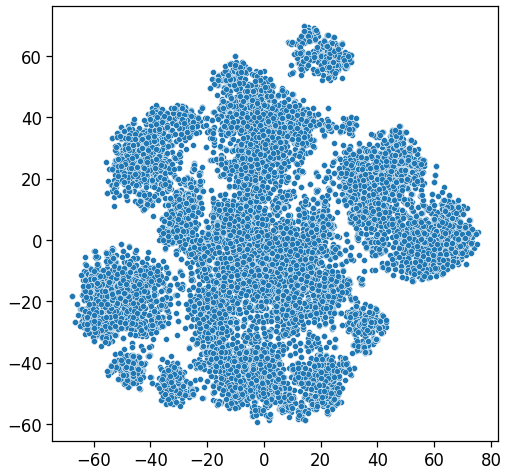

In [ ]:
import seaborn as sns
plt.figure(figsize=(8, 8))
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

sns.scatterplot(tsne_x[:, 0], tsne_x[:, 1])
plt.show()

In [ ]:
for idx, point in enumerate(tsne_x):
  if point[1] > -60 and point[1] < -40:
    if point[0] > 35 and point[0] < 50:
      print(recipes['name'].tolist()[idx])

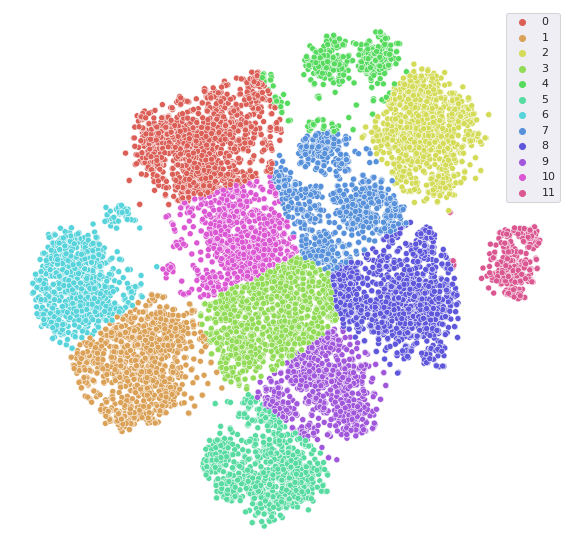

In [ ]:
from sklearn.cluster import KMeans

sns.set_theme()
sns.set_style()

clust = KMeans(n_clusters=12, tol=0).fit_transform(tsne_x)
y = clust.argmin(axis=1)
plt.figure(figsize=(10, 10))
plt.axis('off')
sns.scatterplot(tsne_x[:, 0], tsne_x[:, 1], hue=y, palette=sns.color_palette("hls", len(set(y))))
plt.show()

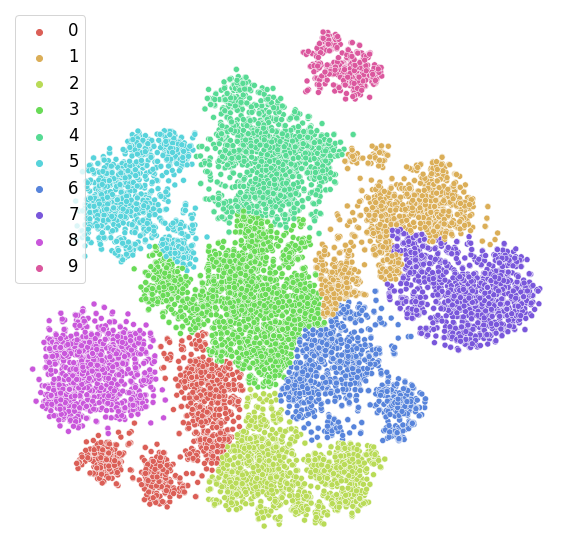

In [ ]:
from sklearn.cluster import AgglomerativeClustering

y = AgglomerativeClustering(n_clusters=10).fit_predict(tsne_x)
plt.figure(figsize=(10, 10))
plt.axis('off')
sns.scatterplot(tsne_x[:, 0], tsne_x[:, 1], hue=y, palette=sns.color_palette("hls", len(set(y))))
plt.show()

In [ ]:
'''
Checking clustering
'''
for i in set(y):
  idx = np.where(y==i)[0].tolist() #, Counter(" ".join(df["data_index"]).split()).most_common(100))
  com = Counter(recipes.iloc[idx]['features'].sum()).most_common(25)
  com = [x[0] for x in com if x[0] not in tags_to_remove]
  print(f'y={i}, Common={com}')

y=0, Common=['poultri', 'chicken', 'lowcarb', 'chickenbreast', 'highinsometh', 'highprotein', 'dinnerparti', '4hoursorless']
y=1, Common=['sidedish', 'vegetarian', '15minutesorless', 'holidayev', '4hoursorless', 'dinnerparti', 'american']
y=2, Common=['pastariceandgrain', 'pasta', 'stovetop', 'sidedish', 'seafood', 'comfortfood', 'dinnerparti', 'onedishm', 'shellfish']
y=3, Common=['dessert', 'cookiesandbrowni', 'kidfriendli', 'holidayev', 'forlargegroup', 'chocol', 'dropcooki', 'barcooki', 'christma', 'gift', 'togo']
y=4, Common=['bread', 'quickbread', 'breakfast', 'healthi', '4hoursorless', 'kidfriendli', 'fruit', 'brunch', 'muffin']
y=5, Common=['lowcholesterol', 'lowcalori', 'lowsaturatedfat', 'healthy2', 'healthi', 'lowprotein', 'lowfat', 'lowsodium', 'lowcarb', 'vegetarian']
y=6, Common=['dessert', 'cake', 'fruit', '4hoursorless', 'lowprotein', 'holidayev', 'kidfriendli', 'lowsodium', 'dinnerparti', 'american']
y=7, Common=['beef', 'groundbeef', 'lowcarb', 'weeknight', 'comfortfo

In [ ]:
by_user = clickstream_tr.groupby(by='user_id')['recipe_id'].apply(list).to_dict()

recipe_map = dict(zip(recipes['id'], range(len(recipes))))

results = []

for u, items in by_user.items():
  clusters = [y[recipe_map[inv_recipe_map[i]]] for i in items]
  results.append(len(set(clusters)))

print(f'Users in all clusters: {results.count(10)}')

import statistics
print(f'Mean: {statistics.mean(results)}')
print(f'Median: {statistics.median(results)}')
print(f'Mode: {statistics.mode(results)}')
print(f'Std Dev: {statistics.stdev(results)}')
# print(by_user)

Users in all clusters: 371
Mean: 5.444080996884735
Median: 5.0
Mode: 4
Std Dev: 2.0623479540831178


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

vectorizer = TfidfVectorizer(max_df=3000, min_df=5, stop_words='english')

corpus = recipes['features'].apply(lambda s: ' '.join(s))
tfidf_matrix = vectorizer.fit_transform(corpus.values)
print(vectorizer.vocabulary_)

cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)
# scores = np.flip(np.sort(cosine_similarities, axis=1)[:, -10:], axis=-1)
# cosine_similarities = np.flip(np.argsort(cosine_similarities, axis=1)[:, -10:], axis=-1)
recipe_map = dict(zip(recipes['id'], range(len(recipes))))

user_scores = np.zeros((clickstream_tr['user_id'].nunique() + 1, tfidf_matrix.shape[0]))
print(user_scores.shape)
# last_10 = clickstream_tr.groupby(by='user_id').tail(20)
# hr = 0.0
# mrr = 0.0
# for idx, gr_data in clickstream_tr.groupby(by='user_id'):
#   items = [recipe_map[inv_recipe_map[i]] for i in (gr_data['recipe_id'])]
  
#   sim_items = []
#   sim_scores = []
#   for i in items[:-1]:
#     sim_items.extend(cosine_similarities[i].tolist())
#     sim_scores.extend(scores[i].tolist())
#   sim_items = [x for _, x in sorted(zip(sim_scores, sim_items))]

#   if items[-1] in sim_items:
#     hr += 1
#     mrr += (1 / float(sim_items.index(items[-1])+1))
# print(f"{(hr * 100) / idx:.5f}")
# print(f"{(mrr) / idx:.5f}")

{'weeknight': 369, 'pork': 253, 'crockpotslowcook': 93, 'porkchop': 254, '5ingredientsorless': 4, 'appet': 9, 'sidedish': 305, 'eggsdairi': 112, 'american': 7, 'southwesternunitedst': 317, 'vegetarian': 363, 'chees': 62, 'deepfri': 101, 'oamcfreezermakeahead': 224, 'techniqu': 344, 'lunch': 198, 'wildgam': 375, 'deer': 102, 'casserol': 56, 'potluck': 260, 'lowcalori': 191, 'lowcarb': 192, 'inexpens': 167, 'togo': 351, 'grill': 144, 'pasta': 236, 'asian': 11, 'beginnercook': 26, 'pastariceandgrain': 237, 'forlargegroup': 124, 'verylowcarb': 365, 'beef': 21, 'stovetop': 332, 'sandwich': 288, 'groundbeef': 145, 'breakfast': 37, 'for1or2': 123, 'sauc': 289, 'condimentsetc': 86, 'dinnerparti': 105, 'holidayev': 162, 'valentinesday': 360, 'savorysauc': 292, '15minutesorless': 0, 'refriger': 272, 'garnish': 133, 'smallappli': 307, 'mixer': 211, 'lowprotein': 195, 'freezer': 126, 'lowsodium': 197, 'corn': 90, '4hoursorless': 3, 'seafood': 297, 'fish': 120, 'lowcholesterol': 193, 'lowsaturatedf

In [ ]:
user_scores = np.zeros((clickstream_tr['user_id'].nunique() + 1, tfidf_matrix.shape[0]))
for idx, gr_data in clickstream_tr.groupby(by='user_id'):
  items = [recipe_map[inv_recipe_map[i]] for i in gr_data['recipe_id'].tolist()[-1:]]
  for i in items:
    user_scores[idx] += cosine_similarities[i]
np.save(root_path + 'user_scores.npy', user_scores)

In [ ]:
np.save(root_path + 'user_scores.npy', user_scores)

In [ ]:
for idx, gr_data in clickstream_tr.groupby(by='user_id'):
  items = [recipe_map[inv_recipe_map[i]] for i in (gr_data['recipe_id'])]
  for i in items:
    sims = cosine_similarities[i].tolist()
    print(recipes.iloc[i]['name'])
    for s in sims:
      print(recipes.iloc[s]['name'])
    print()
  break

In [ ]:
'''
TSNE
'''
from sklearn.manifold import TSNE
import time
time_start = time.time()

tsne_x = TSNE(n_components=2).fit_transform(item_features)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

# import seaborn as sns
# plt.figure(figsize=(8, 8))
# sns.set_style('darkgrid')
# sns.set_palette('muted')
# sns.set_context("notebook", font_scale=1.5,
#                 rc={"lines.linewidth": 2.5})
# tsne_data=np.vstack((tsne_x.T,Y.T)).T

# num_classes = len(np.unique(Y))
# palette = np.array(sns.color_palette("hls", num_classes))
# c=palette[Y.astype(np.int)]

# data=pd.DataFrame(tsne_data, columns=['Dim1','Dim2','label'])
# ax=sns.scatterplot(x='Dim1',y='Dim2',data=data,hue='label')
# plt.xlim(-25, 25)
# plt.ylim(-25, 25)
# ax.axis('off')
# ax.axis('tight')
# plt.show()

In [ ]:
'''
Light FM
Attributes
'''
recipes['fm_features'] = recipes[['tags', 'ingredients']].values.tolist()
recipes['fm_features'] = recipes['fm_features'].apply(lambda t: preprocess(' '.join(map(str, t))))

# One-hot encoding for item attributes - using 'text' field which is created
# while pre-processing and combining name, tags, description and ingredients
mlb = MultiLabelBinarizer()
fm_features = mlb.fit_transform(recipes['fm_features'].values)
print(f'No of Features = {fm_features.shape[1]}')

from scipy import sparse
'''
Using Light FM - Taking item attributes during recommendation
'''
fm_train = train.tocsr()
fm_test = test.tocsr()

x = np.concatenate([np.zeros((1,fm_features.shape[1])), fm_features], axis=0)
print(x.shape)

lightfm_model = LightFM(loss='warp',
                no_components=64)
lightfm_model = lightfm_model.fit(fm_train,
                                  item_features=sparse.csr_matrix(x),
                                  epochs=10,
                                  num_threads=16, verbose=True)

user_to_idx = {}
preds = np.zeros((len(set(test.user_ids)), 50))
scores = np.zeros_like(preds)

No of Features = 2019
(12354, 2019)


Epoch: 100%|██████████| 10/10 [00:53<00:00,  5.31s/it]


(12353, 2019)

In [ ]:
from lightfm.evaluation import reciprocal_rank
m = reciprocal_rank(lightfm_model, fm_test, item_features=sparse.csr_matrix(x))
print(m.mean())

0.0013112994


In [ ]:
interactions_sorted = interactions.sort_values(by=['user_id', 'date'])
test1 = interactions_sorted.groupby(by='user_id').tail(1)
train1 = interactions_sorted.drop(test1.index)

from lightfm.data import Dataset

train_ds = Dataset()
train_ds.fit_partial(train1['user_id'].tolist(), train1['recipe_id'].tolist())
train_ds.fit_partial(test1['user_id'].tolist(), test1['recipe_id'].tolist())

# num_users, num_items = train_ds.interactions_shape()
# print('Num users: {}, num_items {}.\n'.format(num_users, num_items))

fm_interactions, fm_weight = train_ds.build_interactions(zip(train1['user_id'].tolist(), train1['recipe_id'].tolist()))
# print(repr(fm_interactions))

items = list(train_ds.mapping()[2].values())

model = LightFM(loss='bpr', no_components=32, learning_rate=0.01, item_alpha=0.002)
model = model.fit(fm_interactions, sample_weight=fm_weight, epochs=10, 
                  num_threads=16, verbose=True)

user_to_idx = {}
preds = np.zeros((len(test1['user_id'].tolist()), 50))
scores = np.zeros_like(preds)
hr = float(0)
for idx, (u, i) in enumerate(zip(test1['user_id'].tolist(), test1['recipe_id'].tolist())):
  p = model.predict(train_ds.mapping()[0][user], items, num_threads=16)
  preds = np.argpartition(p, -50)[-50:]
  preds = preds[np.argsort(p[preds.tolist()])[::-1]]
  hr += int(train_ds.mapping()[2][i] in preds)

print(hr, idx, f"{(hr * 100) / idx:.4f}")
#   user_to_idx[user] = idx
#   p = model.predict(train_ds.mapping()[0][user], items, num_threads=16)
#   # Setting score of seen recipes to -1
#   # p[seen_recipes[user]] = p.min()
#   preds[idx] = np.argpartition(p, -50)[-50:]
#   scores[idx] = p[preds[idx].astype(int)]

# x = np.arange(scores.shape[0]).reshape(-1, 1)
# y = np.flip(scores.argsort(), axis=-1)

# sorted_preds = preds[x, y].astype(int)

# hr = 0.0
# mrr = 0.0
# for u, i in zip(test1['user_id'].tolist(), test1['recipe_id'].tolist()):
#   matched_preds = sorted_preds[user_to_idx[u]] == train_ds.mapping()[2][i]
#   temp_hr = matched_preds.sum()
#   if temp_hr:
#     hr += 1
#     mrr += (1 / float(matched_preds.nonzero()[0][0] + 1))
#     # ndcg += (math.log(2) / math.log(rank + 2))

# print(f"\nHit Rate (%): {float(hr)* 100 / len(test1['user_id'].tolist())}")
# print(f"MRR: {float(mrr) / len(test1['user_id'].tolist())}\n")

# print(reciprocal_rank(lightfm_model, fm_test).mean())

Epoch: 100%|██████████| 10/10 [00:02<00:00,  3.93it/s]


186.0 12839 1.4487


Epoch: 100%|██████████| 10/10 [00:02<00:00,  4.04it/s]
0.003157438